In [1]:
import numpy as np
import pandas as pd

# which model are we going to use
from sklearn.ensemble import RandomForestClassifier

# text vectorizing stuff
from sklearn.feature_extraction.text import TfidfVectorizer

# things to enable scoring and cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from scipy.sparse import hstack

import time

import matplotlib.pyplot as plt
%matplotlib inline

/home/brian/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/brian/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


#### some helper stuff for tracking performance over the duration of the project

In [2]:
def write_model_timestamp(model_type, kfolds, scores, note):
    '''
    Parameters:
    model_type = string description of the model(s) used to make these scores
    kfolds     = how many folds in kfold cross validation used
    scores     = list of ROC AUC avg scores of models for each class, floats should be like 0.9784
    note       = string, whatever is of note about the model, made a change or whatever
    
    Returns:
    None, but writes (appends) a line to scores.txt in the root directory so that progress can be tracked
    The format is:
            time(s)~model_type~kfold~avg_roc_auc~toxic_auc~s_toxic_auc~obscene_auc~threat_auc~insult_auc~i_hate_auc~notes
            
    scores.txt is a tilde '~' seperated CSV like:
        time~model_type~kfold~avg_roc_auc~toxic_auc~s_toxic_auc~obscene_auc~threat_auc~insult_auc~i_hate_auc~notes
        1520303252~0.9794005980274005~note something
    '''

    out_text = "{:10.0f}~{:}~{:2d}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:0.8f}~{:}\n".format(time.time(), 
                                             model_type, 
                                             kfolds, 
                                             np.mean(scores),
                                             scores[0],
                                             scores[1],
                                             scores[2],
                                             scores[3],
                                             scores[4],
                                             scores[5],                                                
                                             note)
    
    with open("../scores.txt", 'a') as out_file:
        out_file.write(out_text)
        
        print("wrote:")
        print(out_text)
        print("to file")

#### Load data and light processing

In [3]:
train = pd.read_csv('../data/train.csv').fillna(' ')
test = pd.read_csv('../data/test.csv').fillna(' ')

train_text = train['comment_text']
test_text = test['comment_text']
all_text = pd.concat([train_text, test_text])

#### Vectorize words from both corpuses (corpi?)

In [4]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 1),
    max_features=50000)    # 10k was initial, 50k seemed to work well in initial testing

word_vectorizer.fit(all_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=50000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents='unicode', sublinear_tf=True,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [5]:
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)

print("train shape:", train_word_features.shape)
print("test shape:", test_word_features.shape)

train shape: (159571, 50000)
test shape: (153164, 50000)


#### Attempt to tune on a single split instead of 10 kfold since that will take forever

    num_ests: 2 AUC:0.7410
    num_ests: 4 AUC:0.7779
    num_ests: 8 AUC:0.7809
    num_ests: 16 AUC:0.7946
    num_ests: 32 AUC:0.7973
    num_ests: 64 AUC:0.7932
    num_ests: 128 AUC:0.7939
    num_ests: 256 AUC:0.7961


ValueError: x and y must have same first dimension, but have shapes (6,) and (8,)

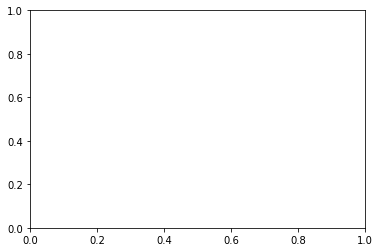

In [13]:
# n_estimators=32, max_depth=512 seems to be the best with simple hparam testing

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for _class in class_names:
    x_train, x_test, y_train, y_test = train_test_split(train_word_features, train[_class], test_size=0.1, random_state=1337)

#     alphas = [4.0, 2.0, 1.0, 0.5, 0.25, 0.12, 0.0600, 0.0300, 0.0150, 0.0075, 0.00375, 0.0019, 0.0009, 0.00045]
    nests = [2, 4, 8, 16, 32, 64, 128, 256]
    depths = [128, 256, 512, 1024, 2048, 4096]
    results = []
    
#     print("Class: {:}".format(_class))
    for nest in nests:
        model = RandomForestClassifier(n_estimators=nest, n_jobs=-1, max_depth=512)
        model.fit(x_train, y_train)

        preds = model.predict(x_test)

        result = roc_auc_score(y_test, preds)
        results.append(result)

        print("    num_ests: {:} AUC:{:0.4f}".format(nest, result))
#     print(" ")
    fig, ax = plt.subplots()
    ax.plot(np.log2(depths), results)
    ax.set_title("Class: {:} Error Relative to Alpha".format(_class))
    ax.set_xlabel("log2 of num_estimators, max_dept=512")
    ax.set_ylabel("ROC AUC")
    

In [ ]:
# max_depth: 128 AUC:0.7062
# max_depth: 256 AUC:0.7644
# max_depth: 512 AUC:0.7929
# max_depth: 1024 AUC:0.7912
# max_depth: 2048 AUC:0.7893
# max_depth: 4096 AUC:0.7769

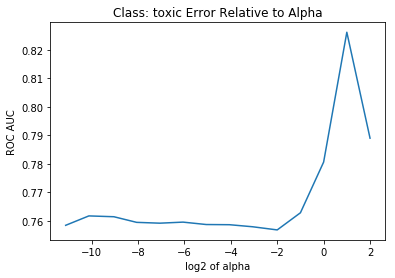

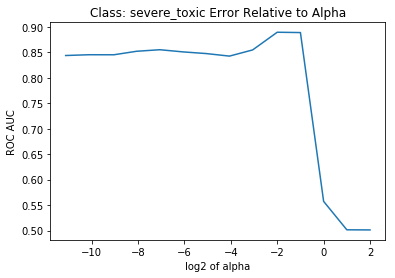

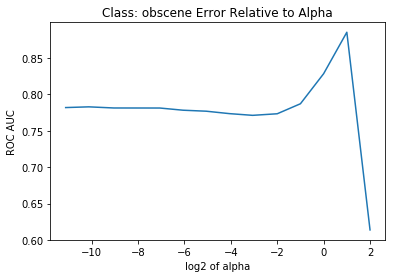

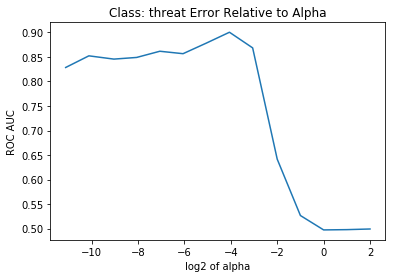

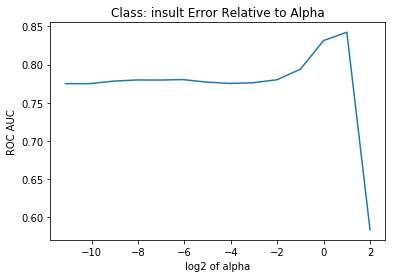

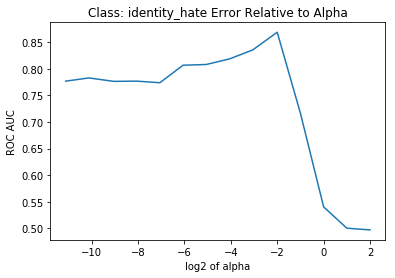

In [40]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for _class in class_names:
    x_train, x_test, y_train, y_test = train_test_split(train_word_features, train[_class], test_size=0.1, random_state=1337)

    alphas = [4.0, 2.0, 1.0, 0.5, 0.25, 0.12, 0.0600, 0.0300, 0.0150, 0.0075, 0.00375, 0.0019, 0.0009, 0.00045]
    
    results = []
    
#     print("Class: {:}".format(_class))
    for _alpha in alphas:
        model = BernoulliNB(alpha=_alpha, fit_prior=False)
        model.fit(x_train, y_train)

        preds = model.predict(x_test)

        result = roc_auc_score(y_test, preds)
        results.append(result)

#         print("    alpha: {:} AUC:{:0.4f}".format( _alpha, result))
#     print(" ")
    fig, ax = plt.subplots()
    ax.plot(np.log2(alphas), results)
    ax.set_title("Class: {:} Error Relative to Alpha".format(_class))
    ax.set_xlabel("log2 of alpha")
    ax.set_ylabel("ROC AUC")
    

In [26]:
scores = []

NUM_FOLDS = 10

train_features = train_word_features.copy()

# submission = pd.DataFrame.from_dict({'id': test['id']})

class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

for class_name in class_names:
    train_target = train[class_name]
    classifier = MultinomialNB(alpha=.03, fit_prior=False)

    kfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=1337)
    
#     results = cross_val_score(classifier, train_features, train_target, cv=5, n_jobs=-1, scoring='roc_auc')
    results = cross_val_score(classifier, train_features, train_target, cv=kfold, scoring='roc_auc')
    
    print('CV Spread for class "{}":'.format(class_name))
    for result in results:
        print("    {:0.4f}".format(result), end=" ")
        
    print(" ")
        
    cv_score = np.mean(results)
    scores.append(cv_score)
    
    print('    CV score for class "{}" is {:0.4}\n'.format(class_name, cv_score))

    classifier.fit(train_features, train_target)
#     submission[class_name] = classifier.predict_proba(test_features)[:, 1]

print('Total CV score is {:0.4f}'.format(np.mean(scores)))

write_model_timestamp('Multinomial NB', NUM_FOLDS, scores, "word2vec max 50k features, fit_prior=False, alpha=0.03")

CV Spread for class "toxic":
    0.9469     0.9384     0.9467     0.9470     0.9448     0.9483     0.9411     0.9461     0.9455     0.9437  
    CV score for class "toxic" is 0.9449

CV Spread for class "severe_toxic":
    0.9732     0.9690     0.9606     0.9784     0.9776     0.9657     0.9732     0.9734     0.9766     0.9684  
    CV score for class "severe_toxic" is 0.9716

CV Spread for class "obscene":
    0.9527     0.9565     0.9420     0.9580     0.9562     0.9482     0.9585     0.9603     0.9522     0.9513  
    CV score for class "obscene" is 0.9536

CV Spread for class "threat":
    0.9505     0.9262     0.9604     0.9407     0.9447     0.9618     0.9655     0.9515     0.9502     0.9144  
    CV score for class "threat" is 0.9466

CV Spread for class "insult":
    0.9566     0.9558     0.9493     0.9525     0.9578     0.9514     0.9503     0.9531     0.9569     0.9514  
    CV score for class "insult" is 0.9535

CV Spread for class "identity_hate":
    0.9475     0.9498     

In [44]:
print("{: <14} {:}".format("CLASS", "AVG ROC AUC"))

for item in zip(class_names, scores):
    print("{: <14} {:0.4f}".format(item[0], item[1]))

CLASS          AVG ROC AUC
toxic          0.9698
severe_toxic   0.9859
obscene        0.9854
threat         0.9828
insult         0.9765
identity_hate  0.9761
